## Import Library

In [57]:
from pyspark.sql import SparkSession, types
from pyspark.sql import functions as F
from pyspark.sql import window as W
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools.dist
import matplotlib.ticker as mticker
import io
from google.cloud import storage

## Setup StandAlone Spark Cluster

In [ ]:
load_dotenv()

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.36.1") \
    .config("spark.jars", "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
     .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
     .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
     .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
     .config("spark.hadoop.google.cloud.auth.type", "SERVICE_ACCOUNT_JSON_KEYFILE") \
     .config("spark.hadoop.fs.gs.project.id", os.getenv('PROJECT_ID')) \
     .appName("participants_survey") \
     .getOrCreate()

:: loading settings :: url = jar:file:/home/Bagas/spark/spark-3.5.5-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/Bagas/.ivy2/cache
The jars for the packages stored in: /home/Bagas/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8b21c6bc-95c4-4cba-b668-a6f5553550d6;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.36.1 in central
:: resolution report :: resolve 207ms :: artifacts dl 6ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.36.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	-------------------------------------------------------------------

In [4]:
spark

## Load and Set Schema 

In [5]:
# Load Data
base_dir = "gs://project-abd/raw/"
participant_info_dir = os.path.join(base_dir, "participant_class_info/")
survey_dir = os.path.join(base_dir, "survey/")

try:
    df_student = spark.read.csv(os.path.join(participant_info_dir, "student.csv"),
                                header=True,
                                inferSchema=True)
    df_class = spark.read.csv(os.path.join(participant_info_dir, "class_table.csv"),
                                header=True,
                                inferSchema=True)
    df_survey = spark.read.csv(os.path.join(survey_dir, "student_survey.csv"),
                                header=True,
                                inferSchema=True)
except Exception as e:
    print(f'Error reading data from GCS : {e}')

In [6]:
# Schema for student_info dataset
student_info_schema = types.StructType([
     types.StructField('Pid', types.IntegerType(), True),
     types.StructField('Gender', types.StringType(), True),
     types.StructField('Age', types.IntegerType(), True),
     types.StructField('Form Room', types.StringType(), True),
     types.StructField('Math Room', types.StringType(), True),
     types.StructField('Language Room', types.StringType(), True),
     types.StructField('What is your general feeling in the classroom? - 1', types.IntegerType(), True),
     types.StructField("When I am engaged in class: - I usually don't feel too hot or too cold.", types.StringType(), True),
     types.StructField('When I am engaged in class: - I could get distracted when the room is too hot or too cold.', types.StringType(), True),
 ])
for field in student_info_schema.fields:
     df_student = df_student.withColumn(field.name, F.col(f"`{field.name}`").cast(field.dataType))

df_student = df_student.withColumnRenamed("What is your general feeling in the classroom? - 1", "General Feeling in Classroom")
df_student = df_student.withColumnRenamed("When I am engaged in class: - I usually don't feel too hot or too cold.", "I usually don't feel too hot or cold in class (Engaged)")
df_student = df_student.withColumnRenamed("When I am engaged in class: - I could get distracted when the room is too hot or too cold.", "Distracted by Temperature (Engaged)")

In [7]:
# Schema for class_table dataset
class_schema = types.StructType([
     types.StructField('Class_id', types.IntegerType(), True),
     types.StructField('Room', types.StringType(), True),
     types.StructField('Start_time', types.TimestampType(), True),
     types.StructField('Finish_time', types.TimestampType(), True),
     types.StructField('Class_len', types.StringType(), True),
     types.StructField('Week', types.IntegerType(), True),
     types.StructField('Weekday', types.IntegerType(), True),
     types.StructField("Class_no", types.IntegerType(), True),
     types.StructField('Subject', types.StringType(), True),
     types.StructField('is_Form', types.StringType(), True),
 ])
for field in class_schema.fields:
     df_class = df_class.withColumn(field.name, F.col(f"`{field.name}`").cast(field.dataType))


In [8]:
# Schema for student_survey dataset
survey_schema = types.StructType([
     types.StructField('Pid', types.IntegerType(), True),
     types.StructField('Week', types.IntegerType(), True),
     types.StructField('Weekday', types.IntegerType(), True),
     types.StructField('Time', types.TimestampType(), True),
     types.StructField('Thermal_sensation', types.IntegerType(), True),
     types.StructField('Thermal_preference', types.StringType(), True),
     types.StructField('Clothing', types.StringType(), True),
     types.StructField("Loc_x", types.IntegerType(), True),
     types.StructField('Loc_y', types.IntegerType(), True),
     types.StructField('Engage_1', types.StringType(), True),
     types.StructField('Engage_2', types.StringType(), True),
     types.StructField('Engage_3', types.StringType(), True),
     types.StructField('Engage_4', types.StringType(), True),
     types.StructField('Engage_5', types.StringType(), True),
     types.StructField('Arousal', types.IntegerType(), True),
     types.StructField('Valence', types.IntegerType(), True),
     types.StructField('Confidence_level', types.IntegerType(), True),
 ])
for field in survey_schema.fields:
     df_survey = df_survey.withColumn(field.name, F.col(f"`{field.name}`").cast(field.dataType))

## EDA for Student Info Dataset

In [9]:
#Check Student Info Total Data
print('Student Info Total Data')
df_student.count()

Student Info Total Data


23

In [10]:
null_value = df_student.select([F.sum(F.col(cols).isNull().cast('int')).alias(cols) for cols in df_student.columns])
null_value.show()

+---+------+---+---------+---------+-------------+----------------------------+-------------------------------------------------------+-----------------------------------+
|Pid|Gender|Age|Form Room|Math Room|Language Room|General Feeling in Classroom|I usually don't feel too hot or cold in class (Engaged)|Distracted by Temperature (Engaged)|
+---+------+---+---------+---------+-------------+----------------------------+-------------------------------------------------------+-----------------------------------+
|  0|     0|  0|        0|        0|            0|                           0|                                                      0|                                  0|
+---+------+---+---------+---------+-------------+----------------------------+-------------------------------------------------------+-----------------------------------+



In [11]:
# Student Info Basic Information
print('Student Info Dataset Schema')
df_student.printSchema()
print('\n Dataset Sample')
df_student.show(5)
print('\n Null Checks')
df_student.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_student.columns]).show()

Student Info Dataset Schema
root
 |-- Pid: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Form Room: string (nullable = true)
 |-- Math Room: string (nullable = true)
 |-- Language Room: string (nullable = true)
 |-- General Feeling in Classroom: integer (nullable = true)
 |-- I usually don't feel too hot or cold in class (Engaged): string (nullable = true)
 |-- Distracted by Temperature (Engaged): string (nullable = true)


 Dataset Sample


+---+------+---+---------+---------+-------------+----------------------------+-------------------------------------------------------+-----------------------------------+
|Pid|Gender|Age|Form Room|Math Room|Language Room|General Feeling in Classroom|I usually don't feel too hot or cold in class (Engaged)|Distracted by Temperature (Engaged)|
+---+------+---+---------+---------+-------------+----------------------------+-------------------------------------------------------+-----------------------------------+
|  1|Female| 16|       R3|       R3|           R1|                           0|                                      Somewhat disagree|                     Somewhat agree|
|  2|Female| 17|       R3|       R1|           R1|                           0|                                      Somewhat disagree|               Neither agree nor...|
|  3|  Male| 16|       R3|       R2|           R4|                          -1|                                      Somewhat disagree|     

+---+------+---+---------+---------+-------------+----------------------------+-------------------------------------------------------+-----------------------------------+
|Pid|Gender|Age|Form Room|Math Room|Language Room|General Feeling in Classroom|I usually don't feel too hot or cold in class (Engaged)|Distracted by Temperature (Engaged)|
+---+------+---+---------+---------+-------------+----------------------------+-------------------------------------------------------+-----------------------------------+
|  0|     0|  0|        0|        0|            0|                           0|                                                      0|                                  0|
+---+------+---+---------+---------+-------------+----------------------------+-------------------------------------------------------+-----------------------------------+



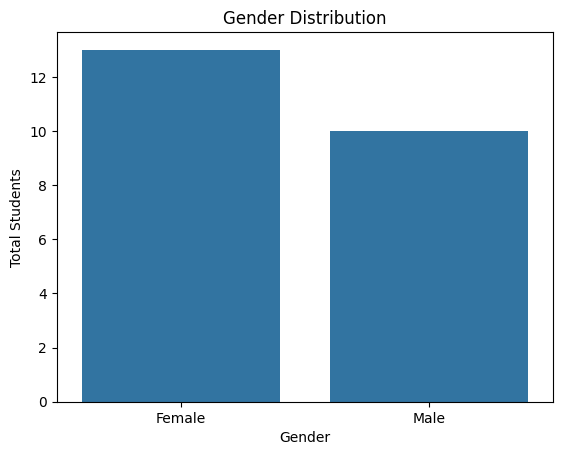

In [12]:
# Gender Distribution 
gender_pd = df_student.select(["Pid", "Gender"]).toPandas()
count_gender = gender_pd.groupby("Gender")['Pid'].nunique().reset_index()
count_gender.columns = ["Gender", "TotalPid"]

sns.barplot(data=count_gender, x='Gender', y='TotalPid')
plt.title("Gender Distribution")
plt.ylabel("Total Students")
plt.xlabel("Gender")
plt.show()

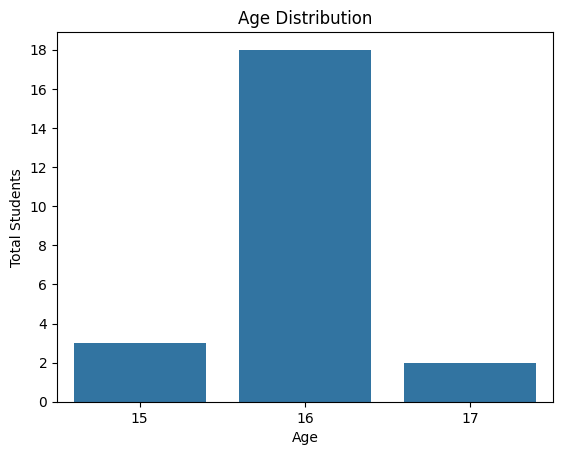

In [13]:
# Age Distribution 
Age_pd = df_student.select(["Pid", "Age"]).toPandas()
count_Age = Age_pd.groupby("Age")['Pid'].nunique().reset_index()
count_Age.columns = ["Age", "TotalPid"]

sns.barplot(data=count_Age, x='Age', y='TotalPid')
plt.title("Age Distribution")
plt.ylabel("Total Students")
plt.xlabel("Age")
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.show()

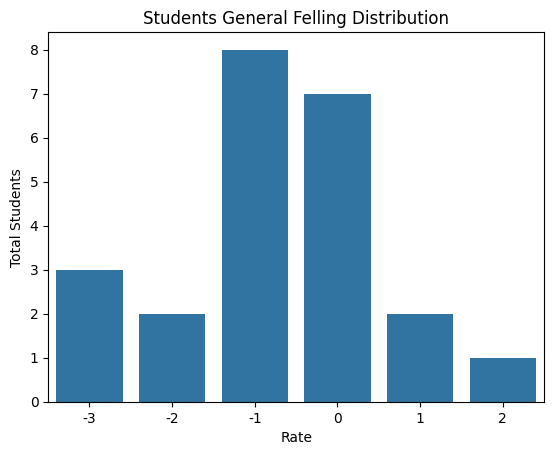

In [14]:
# Students General Feeling in Classrooms
feeling_pd = df_student.select("General feeling in classroom").toPandas()

sns.countplot(data=feeling_pd, x="General feeling in classroom")
plt.title("Students General Felling Distribution")
plt.ylabel("Total Students")
plt.xlabel("Rate")
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.show()

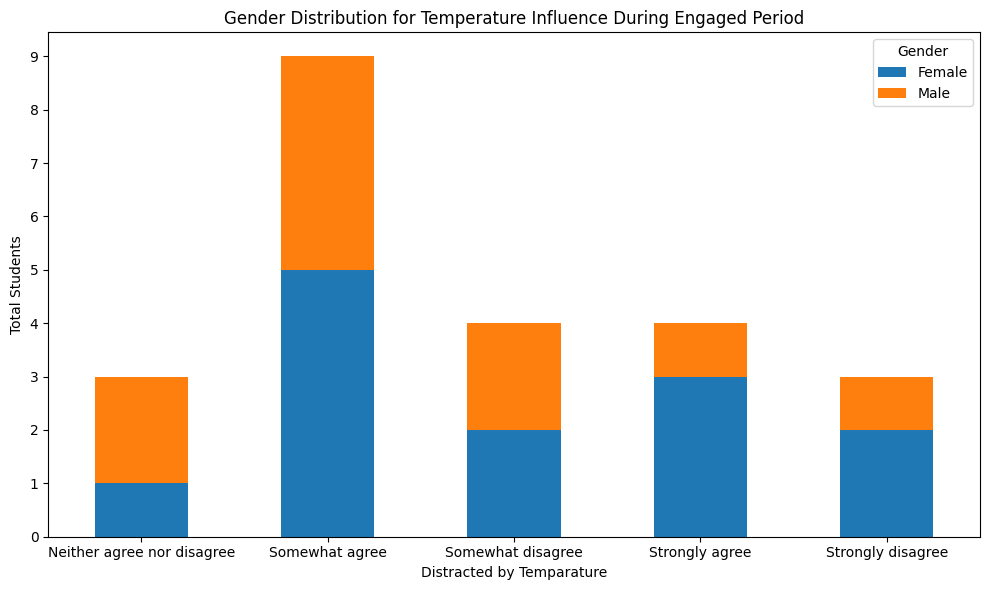

In [15]:
# Gender Distrubution for Temperatrue Influence during Engaged Period
df_temperature = df_student.groupBy("Gender") \
    .pivot("Distracted by Temperature (Engaged)") \
    .count() 
    
temperature_pd = df_temperature.toPandas()
temperature_stacked = temperature_pd.set_index("Gender").T
temperature_stacked.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.title("Gender Distribution for Temperature Influence During Engaged Period")
plt.ylabel("Total Students")
plt.xlabel("Distracted by Temparature")
plt.xticks(rotation=360)
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

In [16]:
df_student.show(5)

+---+------+---+---------+---------+-------------+----------------------------+-------------------------------------------------------+-----------------------------------+
|Pid|Gender|Age|Form Room|Math Room|Language Room|General Feeling in Classroom|I usually don't feel too hot or cold in class (Engaged)|Distracted by Temperature (Engaged)|
+---+------+---+---------+---------+-------------+----------------------------+-------------------------------------------------------+-----------------------------------+
|  1|Female| 16|       R3|       R3|           R1|                           0|                                      Somewhat disagree|                     Somewhat agree|
|  2|Female| 17|       R3|       R1|           R1|                           0|                                      Somewhat disagree|               Neither agree nor...|
|  3|  Male| 16|       R3|       R2|           R4|                          -1|                                      Somewhat disagree|     

## EDA for Class Table Dataset

In [17]:
# Check Class Table Total Data
print('Class Table Total Data')
df_class.count()

Class Table Total Data


248

In [18]:
# Class Info Basic Information
print('\nClass Info Dataset Schema')
df_class.printSchema()
print('\n Dataset Sample')
df_class.show(5)
print('\n Null Check')
df_class.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_class.columns]).show()


Class Info Dataset Schema
root
 |-- Class_id: integer (nullable = true)
 |-- Room: string (nullable = true)
 |-- Start_time: timestamp (nullable = true)
 |-- Finish_time: timestamp (nullable = true)
 |-- Class_len: string (nullable = true)
 |-- Week: integer (nullable = true)
 |-- Weekday: integer (nullable = true)
 |-- Class_no: integer (nullable = true)
 |-- Subject: string (nullable = true)
 |-- is_Form: string (nullable = true)


 Dataset Sample


+--------+----+-------------------+-------------------+---------+----+-------+--------+--------+-------+
|Class_id|Room|         Start_time|        Finish_time|Class_len|Week|Weekday|Class_no| Subject|is_Form|
+--------+----+-------------------+-------------------+---------+----+-------+--------+--------+-------+
|       1|  R6|2025-06-02 09:00:00|2025-06-02 09:40:00|    short|   1|      1|       1|Assembly|    all|
|       2|  R3|2025-06-02 09:40:00|2025-06-02 11:00:00|     long|   1|      1|       2|Language|      0|
|       3|  R3|2025-06-02 11:25:00|2025-06-02 12:05:00|    short|   1|      1|       3|    Form|     R3|
|       4|  R3|2025-06-02 12:05:00|2025-06-02 13:25:00|     long|   1|      1|       4|   Maths|      0|
|       5|  R3|2025-06-02 14:15:00|2025-06-02 15:35:00|     long|   1|      1|       5| English|     R3|
+--------+----+-------------------+-------------------+---------+----+-------+--------+--------+-------+
only showing top 5 rows


 Null Check


+--------+----+----------+-----------+---------+----+-------+--------+-------+-------+
|Class_id|Room|Start_time|Finish_time|Class_len|Week|Weekday|Class_no|Subject|is_Form|
+--------+----+----------+-----------+---------+----+-------+--------+-------+-------+
|       0|   0|         0|          0|        0|   0|      0|       0|      0|      0|
+--------+----+----------+-----------+---------+----+-------+--------+-------+-------+



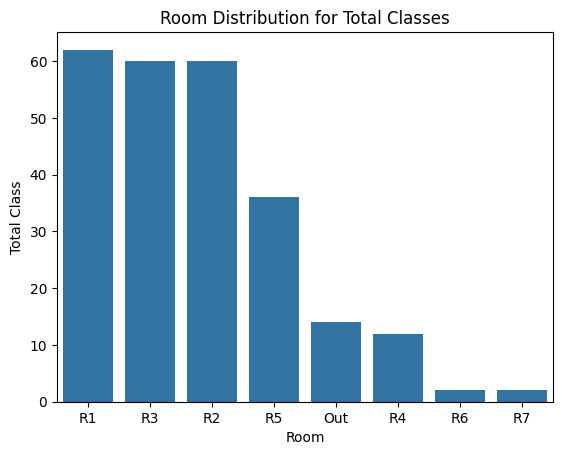

In [19]:
# Rooms distribution for each classes
class_distribution = df_class.groupBy('Room').count().withColumnRenamed("count","Total Class")
class_distribution = class_distribution.sort('Total Class', ascending=False)
class_distribution_pd = class_distribution.toPandas()

sns.barplot(data=class_distribution_pd, x='Room',y='Total Class')
plt.title('Room Distribution for Total Classes')
plt.show()

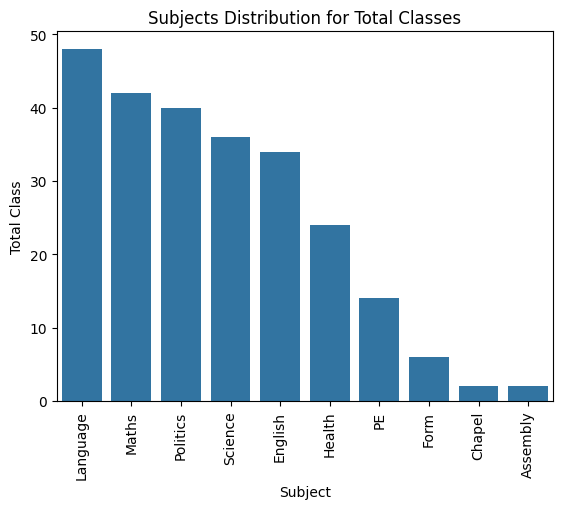

In [20]:
# Subject distribution for each classes
subject_distribution = df_class.groupBy('Subject').count().withColumnRenamed("count","Total Class")
subject_distribution = subject_distribution.sort('Total Class', ascending=False)
subject_distribution_pd = subject_distribution.toPandas()

sns.barplot(data=subject_distribution_pd, x='Subject',y='Total Class')
plt.title('Subjects Distribution for Total Classes')
plt.xticks(rotation=90)
plt.show()

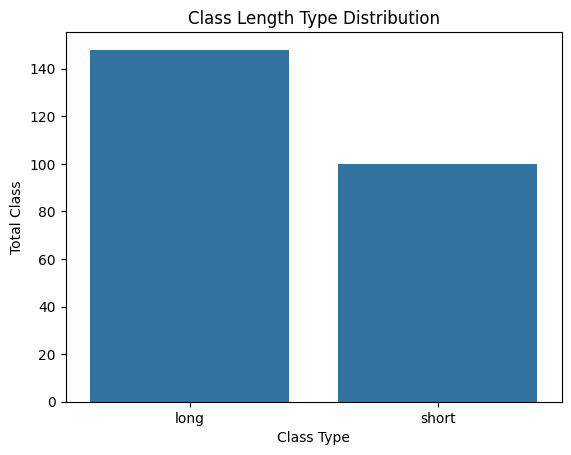

In [21]:
# Distribution for each class type
class_type_distribution = df_class.groupBy('Class_len').count().withColumnRenamed("count","Total Class")
class_type_distribution_pd = class_type_distribution.toPandas()

sns.barplot(data=class_type_distribution_pd, x='Class_len',y='Total Class')
plt.xlabel('Class Type')

plt.title('Class Length Type Distribution')
plt.show()

In [22]:
# Class duration in minutes
class_minutes = df_class.withColumn('Class Duration (Minutes)', 
                                    F.round((F.unix_timestamp('Finish_time') - F.unix_timestamp('Start_time')
                                           )/60,1)
                                    )
class_minutes.groupBy('Class_len').agg(
    F.avg('Class Duration (Minutes)').alias('Average Class Duration'),
    F.max('Class Duration (Minutes)').alias('Maximum Class Duration'),
    F.min('Class Duration (Minutes)').alias('Minimum Class Duration')
).show()

+---------+----------------------+----------------------+----------------------+
|Class_len|Average Class Duration|Maximum Class Duration|Minimum Class Duration|
+---------+----------------------+----------------------+----------------------+
|     long|     79.45945945945945|                  80.0|                  40.0|
|    short|                  40.0|                  40.0|                  40.0|
+---------+----------------------+----------------------+----------------------+



<function matplotlib.pyplot.show(close=None, block=None)>

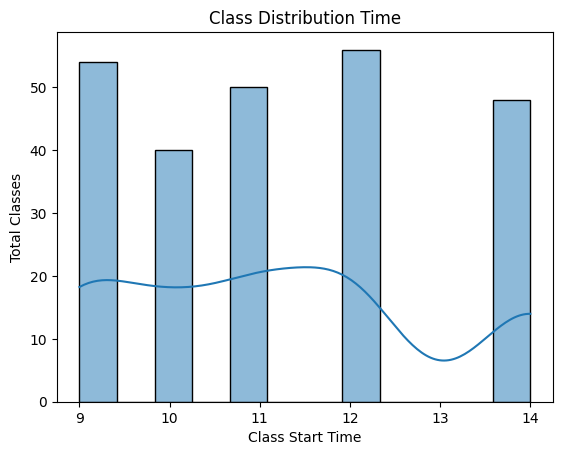

In [23]:
# Daily class time distribution
df_hour = df_class.withColumn('Start_hour', F.hour('Start_time'))
df_hour = df_hour.withColumn('Finish_hour', F.hour('Finish_time'))

hour_df = df_hour.select('Start_hour', 'Finish_hour').toPandas()
sns.histplot(hour_df['Start_hour'], bins=12, kde=True)
plt.title('Class Distribution Time')
plt.ylabel('Total Classes')
plt.xlabel('Class Start Time')
plt.show

In [24]:
# Total class distribution in a week
weekly_class = df_class.groupBy('Weekday').count().withColumnRenamed('count', 'Total Classes')
weekly_class.show()

+-------+-------------+
|Weekday|Total Classes|
+-------+-------------+
|      1|           60|
|      5|           62|
|      4|           66|
|      2|           60|
+-------+-------------+



In [25]:
df_class.show(5)

+--------+----+-------------------+-------------------+---------+----+-------+--------+--------+-------+
|Class_id|Room|         Start_time|        Finish_time|Class_len|Week|Weekday|Class_no| Subject|is_Form|
+--------+----+-------------------+-------------------+---------+----+-------+--------+--------+-------+
|       1|  R6|2025-06-02 09:00:00|2025-06-02 09:40:00|    short|   1|      1|       1|Assembly|    all|
|       2|  R3|2025-06-02 09:40:00|2025-06-02 11:00:00|     long|   1|      1|       2|Language|      0|
|       3|  R3|2025-06-02 11:25:00|2025-06-02 12:05:00|    short|   1|      1|       3|    Form|     R3|
|       4|  R3|2025-06-02 12:05:00|2025-06-02 13:25:00|     long|   1|      1|       4|   Maths|      0|
|       5|  R3|2025-06-02 14:15:00|2025-06-02 15:35:00|     long|   1|      1|       5| English|     R3|
+--------+----+-------------------+-------------------+---------+----+-------+--------+--------+-------+
only showing top 5 rows



## EDA for Student Survey Dataset

In [26]:
# Check Survey Total Data
print('Survey Total Data')
df_survey.count()

Survey Total Data


488

In [27]:
# Survey Basic Information
print('Student Survey Dataset Schema')
df_survey.printSchema()
print('\n Dataset Sample')
df_survey.show(5)
print('\n Null Check')
df_survey.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_survey.columns]).show()

Student Survey Dataset Schema
root
 |-- Pid: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- Weekday: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Thermal_sensation: integer (nullable = true)
 |-- Thermal_preference: string (nullable = true)
 |-- Clothing: string (nullable = true)
 |-- Loc_x: integer (nullable = true)
 |-- Loc_y: integer (nullable = true)
 |-- Engage_1: string (nullable = true)
 |-- Engage_2: string (nullable = true)
 |-- Engage_3: string (nullable = true)
 |-- Engage_4: string (nullable = true)
 |-- Engage_5: string (nullable = true)
 |-- Arousal: integer (nullable = true)
 |-- Valence: integer (nullable = true)
 |-- Confidence_level: integer (nullable = true)


 Dataset Sample


+---+----+-------+-------------------+-----------------+------------------+--------------------+-----+-----+-----------------+--------------------+--------------------+--------------------+--------------------+-------+-------+----------------+
|Pid|Week|Weekday|               Time|Thermal_sensation|Thermal_preference|            Clothing|Loc_x|Loc_y|         Engage_1|            Engage_2|            Engage_3|            Engage_4|            Engage_5|Arousal|Valence|Confidence_level|
+---+----+-------+-------------------+-----------------+------------------+--------------------+-----+-----+-----------------+--------------------+--------------------+--------------------+--------------------+-------+-------+----------------+
|  8|   1|      1|2025-06-02 10:02:00|                1|         No change|Shirt,Jumper,Pant...|  228|  112|Somewhat disagree|      Somewhat agree|      Somewhat agree|Neither agree nor...|      Somewhat agree|   NULL|   NULL|            NULL|
| 18|   1|      1|2025-0

+---+----+-------+----+-----------------+------------------+--------+-----+-----+--------+--------+--------+--------+--------+-------+-------+----------------+
|Pid|Week|Weekday|Time|Thermal_sensation|Thermal_preference|Clothing|Loc_x|Loc_y|Engage_1|Engage_2|Engage_3|Engage_4|Engage_5|Arousal|Valence|Confidence_level|
+---+----+-------+----+-----------------+------------------+--------+-----+-----+--------+--------+--------+--------+--------+-------+-------+----------------+
|  0|   0|      0|   0|                0|                 0|       0|    0|    0|       0|       0|       0|       0|       0|    319|    319|             324|
+---+----+-------+----+-----------------+------------------+--------+-----+-----+--------+--------+--------+--------+--------+-------+-------+----------------+



In [28]:
# Total unique students
df_survey.select('Pid').distinct().count()

23

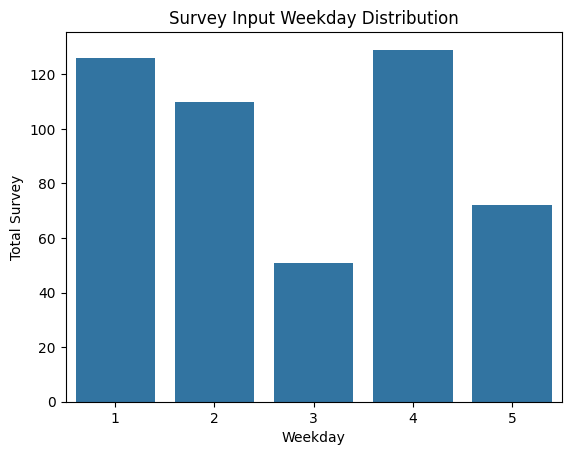

In [29]:
# Survey input days distribution 
survey_dist = df_survey.groupBy("Weekday").count().orderBy("Weekday").withColumnRenamed('count', 'Total_survey')
survey_dist_pd = survey_dist.toPandas()

sns.barplot(survey_dist_pd, x='Weekday', y='Total_survey')
plt.title('Survey Input Weekday Distribution')
plt.ylabel('Total Survey')
plt.show()

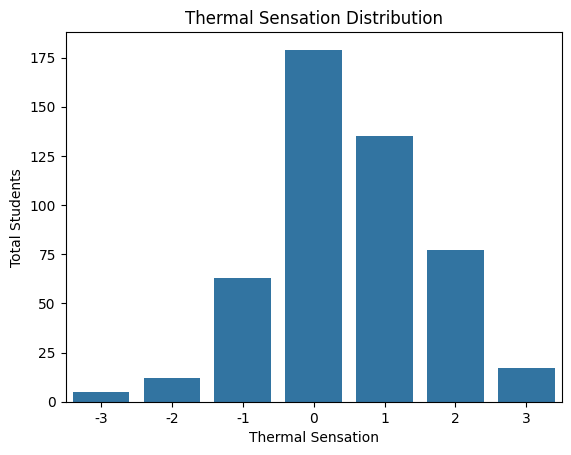

In [30]:
thermal_sensation = df_survey.groupBy('Thermal_sensation').count().orderBy('Thermal_sensation')

sns.barplot(thermal_sensation.toPandas(), x='Thermal_sensation', y='count')
plt.title('Thermal Sensation Distribution')
plt.xlabel('Thermal Sensation')
plt.ylabel('Total Students')
plt.show()

Text(0.5, 1.0, 'Thermal Sensation and Therma Preference Correlation')

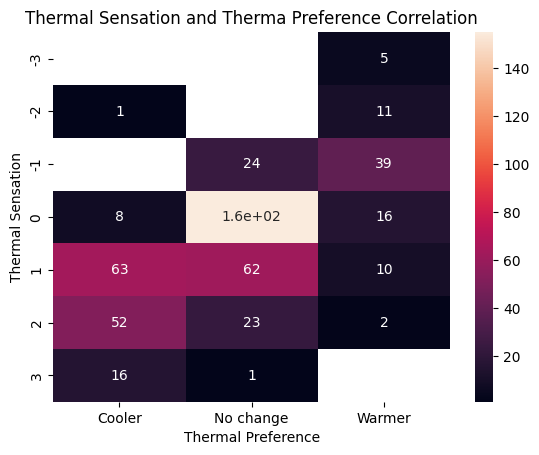

In [31]:
thermal_pivot = df_survey.groupBy('Thermal_sensation', 'Thermal_preference').count().toPandas().pivot(
    index = 'Thermal_sensation', columns = 'Thermal_preference', values = 'count'
)

sns.heatmap(thermal_pivot, annot=True)
plt.xlabel('Thermal Preference')
plt.ylabel('Thermal Sensation')
plt.title('Thermal Sensation and Therma Preference Correlation')

In [32]:
clothing_df = df_survey.withColumn('Clothing', F.explode(F.split('Clothing', ',')))
clothing_df.groupBy('Clothing').count().withColumnRenamed('count','Total').orderBy('Total', ascending=False).show()

+--------+-----+
|Clothing|Total|
+--------+-----+
|   Shirt|  417|
|  Jumper|  196|
|  Shorts|  195|
|   Pants|  179|
|  Jacket|  140|
|   Skirt|   95|
|   Other|   83|
|   Dress|   58|
+--------+-----+



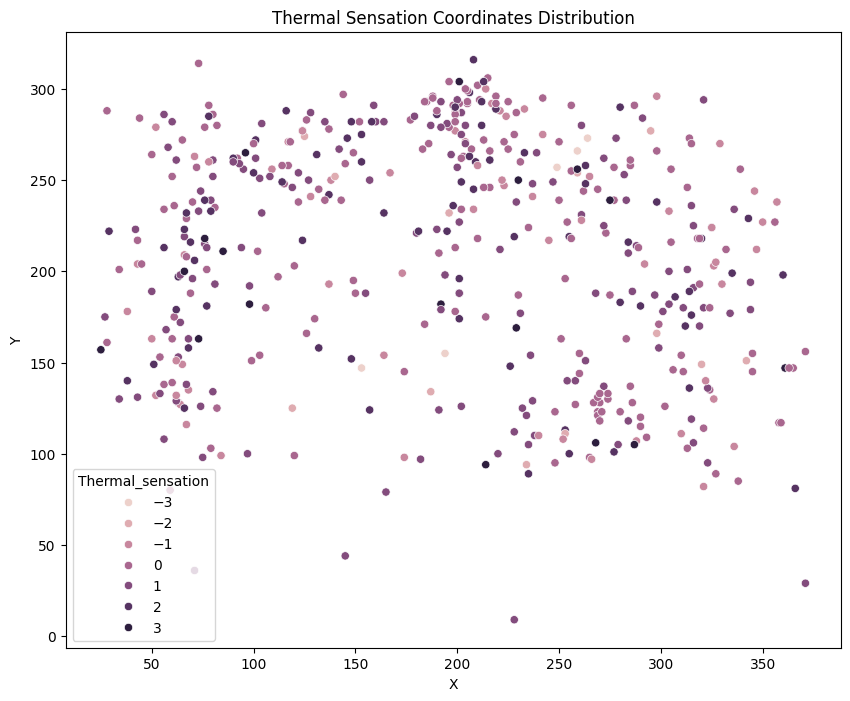

In [33]:
loc_df = df_survey.select('Loc_x', 'Loc_y', 'Thermal_sensation').toPandas()

plt.figure(figsize=(10,8))
sns.scatterplot(loc_df, x='Loc_x', y='Loc_y', hue='Thermal_sensation')
plt.title('Thermal Sensation Coordinates Distribution')
plt.ylabel('Y')
plt.xlabel('X')
plt.show()

In [34]:
engage_cols = ["Engage_1", "Engage_2", "Engage_3", "Engage_4", "Engage_5"]
for colname in engage_cols:
    df_survey = df_survey.withColumn(colname, F.when(F.col(colname).isNotNull(), F.col(colname)).otherwise("Missing"))

df_engage = df_survey.groupBy("Pid").agg(*[F.count(F.when(F.col(col) == "Strongly agree", col)).alias(f"{col} Strongly Agree") for col in engage_cols])
df_engage.show()

+---+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|Pid|Engage_1 Strongly Agree|Engage_2 Strongly Agree|Engage_3 Strongly Agree|Engage_4 Strongly Agree|Engage_5 Strongly Agree|
+---+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
| 12|                      1|                      0|                      0|                      0|                      0|
| 22|                      8|                      1|                      5|                      0|                      2|
|  1|                      9|                      0|                      6|                      2|                     15|
| 13|                      1|                      2|                      0|                      3|                      4|
|  6|                      1|                      2|                      0|                      0|                 

In [35]:
def engagement_score(col_name):
    return F.when(F.col(col_name) == "Strongly agree", 2)\
            .when(F.col(col_name) == "Somewhat agree", 1)\
            .when(F.col(col_name) == "Neither agree nor disagree", 0)\
            .when(F.col(col_name) == "Somewhat disagree", -1)\
            .when(F.col(col_name) == "Strongly disagree", -2)\
            .otherwise(0)

df_engage_score = df_survey.withColumn("E1_score", engagement_score("Engage_1")) \
                           .withColumn("E2_score", engagement_score("Engage_2")) \
                           .withColumn("E3_score", engagement_score("Engage_3")) \
                           .withColumn("E4_score", engagement_score("Engage_4")) \
                           .withColumn("E5_score", engagement_score("Engage_5"))

df_engage_score = df_engage_score.withColumn(
    "engagements_score",
    F.expr("E1_score + E2_score + E3_score + E4_score + E5_score")
)

df_engage_score = df_engage_score.drop("E1_score", "E2_score", "E3_score", "E4_score", "E5_score")
df_engage_score = df_engage_score.withColumn('Avg engagements_score', F.col('engagements_score') / 5)

df_engage_score.groupBy('engagements_score').count().withColumnRenamed('count', 'Engagement Score Distribution').orderBy('Engagement Score Distribution', ascending = False).show()

+-----------------+-----------------------------+
|engagements_score|Engagement Score Distribution|
+-----------------+-----------------------------+
|                0|                           87|
|                1|                           83|
|                2|                           83|
|               -1|                           58|
|                3|                           55|
|               -2|                           44|
|               -3|                           22|
|                5|                           15|
|                4|                           15|
|               -5|                           10|
|               -4|                            8|
|               -6|                            4|
|                6|                            2|
|               -8|                            1|
|                7|                            1|
+-----------------+-----------------------------+



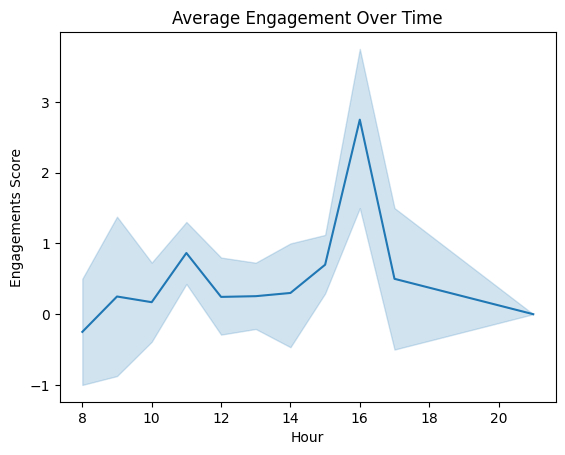

In [36]:
df_time = df_engage_score.withColumn("Hour", F.hour("Time"))
df_time.groupBy("Hour").agg(F.avg("engagements_score")).orderBy("Hour")

time_df = df_time.select("Hour", "engagements_score").toPandas()
sns.lineplot(data=time_df, x="Hour", y="engagements_score")
plt.ylabel('Engagements Score')
plt.title("Average Engagement Over Time")
plt.show()

In [37]:
df_survey.show(5)

+---+----+-------+-------------------+-----------------+------------------+--------------------+-----+-----+-----------------+--------------------+--------------------+--------------------+--------------------+-------+-------+----------------+
|Pid|Week|Weekday|               Time|Thermal_sensation|Thermal_preference|            Clothing|Loc_x|Loc_y|         Engage_1|            Engage_2|            Engage_3|            Engage_4|            Engage_5|Arousal|Valence|Confidence_level|
+---+----+-------+-------------------+-----------------+------------------+--------------------+-----+-----+-----------------+--------------------+--------------------+--------------------+--------------------+-------+-------+----------------+
|  8|   1|      1|2025-06-02 10:02:00|                1|         No change|Shirt,Jumper,Pant...|  228|  112|Somewhat disagree|      Somewhat agree|      Somewhat agree|Neither agree nor...|      Somewhat agree|   NULL|   NULL|            NULL|
| 18|   1|      1|2025-0

## Preprocessing Script

In [38]:
student = df_student
survey = df_survey
table = df_class

In [39]:
student.show(5)

+---+------+---+---------+---------+-------------+----------------------------+-------------------------------------------------------+-----------------------------------+
|Pid|Gender|Age|Form Room|Math Room|Language Room|General Feeling in Classroom|I usually don't feel too hot or cold in class (Engaged)|Distracted by Temperature (Engaged)|
+---+------+---+---------+---------+-------------+----------------------------+-------------------------------------------------------+-----------------------------------+
|  1|Female| 16|       R3|       R3|           R1|                           0|                                      Somewhat disagree|                     Somewhat agree|
|  2|Female| 17|       R3|       R1|           R1|                           0|                                      Somewhat disagree|               Neither agree nor...|
|  3|  Male| 16|       R3|       R2|           R4|                          -1|                                      Somewhat disagree|     

In [40]:
student = student.select('Pid', 'Gender', 'Age')
rename_dict = {
    'Pid': 'student_id',
    'Gender': 'gender_code',
    'Age': 'age',
    'Form Room': 'form_room',
    'Math Room': 'math_room',
    'Language Room': 'language_room'
}

for old_name, new_name in rename_dict.items():
    student = student.withColumnRenamed(old_name, new_name)

student = student.withColumn('gender_code', F.when(F.col('gender_code') == 'female',0).otherwise(1))
student.show(5)


+----------+-----------+---+
|student_id|gender_code|age|
+----------+-----------+---+
|         1|          1| 16|
|         2|          1| 17|
|         3|          1| 16|
|         4|          1| 16|
|         5|          1| 16|
+----------+-----------+---+
only showing top 5 rows



In [41]:
survey.show(5)

+---+----+-------+-------------------+-----------------+------------------+--------------------+-----+-----+-----------------+--------------------+--------------------+--------------------+--------------------+-------+-------+----------------+
|Pid|Week|Weekday|               Time|Thermal_sensation|Thermal_preference|            Clothing|Loc_x|Loc_y|         Engage_1|            Engage_2|            Engage_3|            Engage_4|            Engage_5|Arousal|Valence|Confidence_level|
+---+----+-------+-------------------+-----------------+------------------+--------------------+-----+-----+-----------------+--------------------+--------------------+--------------------+--------------------+-------+-------+----------------+
|  8|   1|      1|2025-06-02 10:02:00|                1|         No change|Shirt,Jumper,Pant...|  228|  112|Somewhat disagree|      Somewhat agree|      Somewhat agree|Neither agree nor...|      Somewhat agree|   NULL|   NULL|            NULL|
| 18|   1|      1|2025-0

In [42]:
survey = survey.withColumn(
    "Timestamp",
    F.from_unixtime(
        (F.unix_timestamp("Time") / 300).cast("integer") * 300
    ).cast("timestamp")
)

survey = survey.drop('Time')

In [43]:
survey = survey.select('Pid','Week','Weekday','Timestamp','Engage_1', 'Engage_2','Engage_3','Engage_4','Engage_5')
survey = survey.withColumn("time", F.date_format("timestamp", "HH:mm:ss"))
survey = survey.drop('timestamp')
survey = survey.withColumnRenamed('Pid', 'student_id')
survey = survey.toDF(*[col.lower() for col in survey.columns])
survey.show(5)

+----------+----+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------+
|student_id|week|weekday|         engage_1|            engage_2|            engage_3|            engage_4|            engage_5|    time|
+----------+----+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------+
|         8|   1|      1|Somewhat disagree|      Somewhat agree|      Somewhat agree|Neither agree nor...|      Somewhat agree|10:00:00|
|        18|   1|      1|   Somewhat agree|Neither agree nor...|Neither agree nor...|   Strongly disagree|   Strongly disagree|10:00:00|
|         3|   1|      1|   Somewhat agree|Neither agree nor...|      Strongly agree|Neither agree nor...|      Strongly agree|10:00:00|
|         9|   1|      1|   Somewhat agree|Neither agree nor...|      Strongly agree|   Somewhat disagree|Neither agree nor...|10:55:00|
|        14|   1|      1|   Somewhat agre

In [44]:
def engagement_score(col_name):
    return F.when(F.col(col_name) == "Strongly agree", 2)\
            .when(F.col(col_name) == "Somewhat agree", 1)\
            .when(F.col(col_name) == "Neither agree nor disagree", 0)\
            .when(F.col(col_name) == "Somewhat disagree", -1)\
            .when(F.col(col_name) == "Strongly disagree", -2)\
            .otherwise(0)

survey = survey.withColumn("E1_score", engagement_score("Engage_1")) \
                           .withColumn("E2_score", engagement_score("Engage_2")) \
                           .withColumn("E3_score", engagement_score("Engage_3")) \
                           .withColumn("E4_score", engagement_score("Engage_4")) \
                           .withColumn("E5_score", engagement_score("Engage_5"))

survey = survey.withColumn(
    "engagements_score",
    F.expr("E1_score + E2_score + E3_score + E4_score + E5_score")
)
survey.show(5)

+----------+----+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+--------+--------+--------+-----------------+
|student_id|week|weekday|         engage_1|            engage_2|            engage_3|            engage_4|            engage_5|    time|E1_score|E2_score|E3_score|E4_score|E5_score|engagements_score|
+----------+----+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+--------+--------+--------+-----------------+
|         8|   1|      1|Somewhat disagree|      Somewhat agree|      Somewhat agree|Neither agree nor...|      Somewhat agree|10:00:00|      -1|       1|       1|       0|       1|                2|
|        18|   1|      1|   Somewhat agree|Neither agree nor...|Neither agree nor...|   Strongly disagree|   Strongly disagree|10:00:00|       1|       0|       0|      -2|      -2|               -3|


In [45]:
survey = survey.drop('Engage_1', 'Engage_2',
                     'Engage_3', 'Engage_4',
                     'Engage_5', 'E1_score',
                     'E2_score', 'E3_score',
                     'E4_score', 'E5_score')

In [ ]:
survey = survey.withColumn("engagement_level",
    (F.col('engagements_score')/ 5))

survey = survey.withColumn("engagement_level",
    F.when(F.col("engagements_score") >= 0, "Engaged")
     .otherwise("Not Engaged")
)
survey = survey.drop('engagements_score')
survey.show(5)

+----------+----+-------+--------+----------------+
|student_id|week|weekday|    time|engagement_level|
+----------+----+-------+--------+----------------+
|         8|   1|      1|10:00:00|  Highly Engaged|
|        18|   1|      1|10:00:00|     Not Engaged|
|         3|   1|      1|10:00:00|  Highly Engaged|
|         9|   1|      1|10:55:00|  Highly Engaged|
|        14|   1|      1|10:55:00|     Not Engaged|
+----------+----+-------+--------+----------------+
only showing top 5 rows



In [47]:
df_joined = student.join(survey, on='student_id', how='left')
df_joined.show()

+----------+-----------+---+----+-------+--------+----------------+
|student_id|gender_code|age|week|weekday|    time|engagement_level|
+----------+-----------+---+----+-------+--------+----------------+
|         1|          1| 16|   4|      5|15:30:00|     Not Engaged|
|         1|          1| 16|   4|      5|14:15:00|     Not Engaged|
|         1|          1| 16|   4|      5|11:25:00|     Not Engaged|
|         1|          1| 16|   4|      1|14:15:00|  Highly Engaged|
|         1|          1| 16|   4|      1|11:25:00|  Highly Engaged|
|         1|          1| 16|   3|      5|15:10:00|     Not Engaged|
|         1|          1| 16|   3|      5|13:10:00|     Not Engaged|
|         1|          1| 16|   3|      5|11:50:00|  Highly Engaged|
|         1|          1| 16|   3|      4|15:35:00|         Engaged|
|         1|          1| 16|   3|      4|14:20:00|     Not Engaged|
|         1|          1| 16|   3|      4|12:00:00|     Not Engaged|
|         1|          1| 16|   3|      2|10:55:0

In [48]:
df_class.show(5)

+--------+----+-------------------+-------------------+---------+----+-------+--------+--------+-------+
|Class_id|Room|         Start_time|        Finish_time|Class_len|Week|Weekday|Class_no| Subject|is_Form|
+--------+----+-------------------+-------------------+---------+----+-------+--------+--------+-------+
|       1|  R6|2025-06-02 09:00:00|2025-06-02 09:40:00|    short|   1|      1|       1|Assembly|    all|
|       2|  R3|2025-06-02 09:40:00|2025-06-02 11:00:00|     long|   1|      1|       2|Language|      0|
|       3|  R3|2025-06-02 11:25:00|2025-06-02 12:05:00|    short|   1|      1|       3|    Form|     R3|
|       4|  R3|2025-06-02 12:05:00|2025-06-02 13:25:00|     long|   1|      1|       4|   Maths|      0|
|       5|  R3|2025-06-02 14:15:00|2025-06-02 15:35:00|     long|   1|      1|       5| English|     R3|
+--------+----+-------------------+-------------------+---------+----+-------+--------+--------+-------+
only showing top 5 rows



In [49]:
table_select = df_class.select('Room',
                               'Class_id',
                               'Weekday',
                               'Week',
                               'Start_time',
                               'Finish_time')
table_select.show(5)

+----+--------+-------+----+-------------------+-------------------+
|Room|Class_id|Weekday|Week|         Start_time|        Finish_time|
+----+--------+-------+----+-------------------+-------------------+
|  R6|       1|      1|   1|2025-06-02 09:00:00|2025-06-02 09:40:00|
|  R3|       2|      1|   1|2025-06-02 09:40:00|2025-06-02 11:00:00|
|  R3|       3|      1|   1|2025-06-02 11:25:00|2025-06-02 12:05:00|
|  R3|       4|      1|   1|2025-06-02 12:05:00|2025-06-02 13:25:00|
|  R3|       5|      1|   1|2025-06-02 14:15:00|2025-06-02 15:35:00|
+----+--------+-------+----+-------------------+-------------------+
only showing top 5 rows



In [50]:
table_select = table_select.withColumnsRenamed({'Weekday':'weekday_1', 'Week':'week_1', 'Room':'room','Class_id':'class_id'})

table_select = table_select.withColumn('start',
                                       F.date_format('Start_time','HH:mm:ss')).drop('Start_time')
table_select = table_select.withColumn('end',
                                       F.date_format('Finish_time','HH:mm:ss')).drop('Finish_time')
table_select.show(5)

+----+--------+---------+------+--------+--------+
|room|class_id|weekday_1|week_1|   start|     end|
+----+--------+---------+------+--------+--------+
|  R6|       1|        1|     1|09:00:00|09:40:00|
|  R3|       2|        1|     1|09:40:00|11:00:00|
|  R3|       3|        1|     1|11:25:00|12:05:00|
|  R3|       4|        1|     1|12:05:00|13:25:00|
|  R3|       5|        1|     1|14:15:00|15:35:00|
+----+--------+---------+------+--------+--------+
only showing top 5 rows



In [51]:
df_combined = df_joined.join(table_select, on=[
    (df_joined['week'] == table_select['week_1']),
    (df_joined['weekday'] == table_select['weekday_1']),
    (df_joined['time'] >= table_select['start']),
    (df_joined['time'] <= table_select['end'])
], how='right')
df_combined = df_combined.drop('week_1','weekday_1','start','end')
df_combined = df_combined.dropna()
df_combined.show(5)

+----------+-----------+---+----+-------+--------+----------------+----+--------+
|student_id|gender_code|age|week|weekday|    time|engagement_level|room|class_id|
+----------+-----------+---+----+-------+--------+----------------+----+--------+
|        15|          1| 16|   1|      1|11:00:00|  Highly Engaged|  R3|       2|
|        20|          1| 16|   1|      1|11:00:00|  Highly Engaged|  R3|       2|
|        13|          1| 16|   1|      1|11:00:00|         Engaged|  R3|       2|
|        23|          1| 16|   1|      1|11:00:00|  Highly Engaged|  R3|       2|
|        21|          1| 15|   1|      1|11:00:00|     Not Engaged|  R3|       2|
+----------+-----------+---+----+-------+--------+----------------+----+--------+
only showing top 5 rows



In [53]:
df_pd = df_combined.toPandas()
csv_buffer = io.StringIO()
df_pd.to_csv(csv_buffer, index=False)
csv_data = csv_buffer.getvalue()
csv_buffer.close()

In [ ]:
client = storage.Client()
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=os.getenv('CREDENTIAL')

In [70]:
bucket = client.get_bucket('project-abd')
destination_file = 'notebook-data/participant_survey.csv'
blob_csv = bucket.blob(destination_file)
blob_csv.upload_from_string(csv_data, content_type='text/csv')
print(f"DataFrame uploaded to gs://{bucket}/{destination_file} as CSV")

DataFrame uploaded to gs://<Bucket: project-abd>/notebook-data/participant_survey.csv as CSV


25/06/02 06:24:02 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
25/06/02 06:24:02 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.errors.SparkCoreErrors$.clusterSchedulerError(SparkCoreErrors.scala:291)
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:981)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:165)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:263)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:170)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.proce